In [2]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle

In [4]:
DATA_DIR = '/mnt/chicm/data/open-images/relation'
DETECT_DATA_DIR = '/mnt/chicm/data/open-images/detect'

In [1]:
!ls $DATA_DIR

catboost_info		   sub_is_all_label2_0724.csv
eda.ipynb		   sub_is_th0.01_0723.csv
Is-classifier-6-eda.ipynb  sub_is_th0.1_0723.csv
Is-detect-42-eda.ipynb	   sub_is_th0.1_all_label2_0723.csv
merge_0726_1.csv.zip	   submit-detect-57.ipynb
merge_0728_1.csv.zip	   submit-is-42.ipynb
merge_df.ipynb		   submit-is-6.ipynb
sub_detect_0722_1.csv	   sub_tuple_0728.csv
sub_detect_0724.csv	   sub_tuple_0728_top25.csv
sub_is_083vt_0724.csv	   sub_tuple_rel_detect_model_0729.csv
sub_is_42_0726_1.csv	   tmp_pos_rel.csv
sub_is_42_0726_2.csv	   tuple-rel-classifier.ipynb


In [5]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_test.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...


In [6]:
df_des = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-classes-vrd.csv'), names=['label', 'name'])
df_des.head()

,label,name
0,/m/05r5c,Piano
1,/m/01599,Beer
2,/m/01_5g,Chopsticks
3,/m/01yrx,Cat
4,/m/04_sv,Motorcycle


In [7]:
df_des.name.values

array(['Piano', 'Beer', 'Chopsticks', 'Cat', 'Motorcycle',
       'Tennis racket', 'Football', 'Mobile phone', 'Flute',
       'Tennis ball', 'Chair', 'Woman', 'Boy', 'Coffee table', 'Handbag',
       'Fork', 'Girl', 'Coffee cup', 'Violin', 'Backpack', 'Knife',
       'Snowboard', 'Rugby ball', 'Snake', 'Oven', 'Microwave oven',
       'Man', 'Bench', 'Desk', 'Suitcase', 'Sofa bed', 'Horse',
       'Microphone', 'Table tennis racket', 'Monkey', 'Surfboard',
       'Table', 'Bottle', 'Mug', 'Wine glass', 'Drum', 'Dog', 'Guitar',
       'Ski', 'Bed', 'Spoon', 'Briefcase', 'Hamster', 'Car', 'Bicycle',
       'Camera', 'Dolphin', 'Taxi', 'Van', 'Elephant', 'Racket',
       'Pretzel'], dtype=object)

In [8]:
def get_classes():
    df_classes = pd.read_csv(os.path.join(DATA_DIR, 'classes_is_42.csv'))
    classes = df_classes['classes'].values.tolist()
    stoi = { classes[i]: i for i in range(len(classes)) }
    return classes, stoi

classes, stoi = get_classes()

In [9]:
classes[:2]

['/m/04dr76w,/m/05z87', '/m/04bcr3,/m/083vt']

In [10]:
# visualize

import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


In [37]:
!ls /mnt/chicm/open-images-vrd/work_dirs/ga_retinanet_x101_32x4d_fpn_1x_is_42  

20190731_025838.log	  20190731_084434.log	    epoch_2.pth
20190731_025838.log.json  20190731_084434.log.json  epoch_3.pth
20190731_030448.log	  20190731_085235.log	    epoch_4.pth
20190731_030639.log	  20190731_085235.log.json  latest.pth
20190731_030639.log.json  epoch_1.pth		    preds_0731.pkl


In [38]:
# submission

with open('/mnt/chicm/open-images-vrd/work_dirs/ga_retinanet_x101_32x4d_fpn_1x_is_42/preds_0731.pkl', 'rb') as f:
    preds = pickle.load(f)


In [39]:
len(preds[0])

42

In [14]:
preds[0]

[array([], shape=(0, 5), dtype=float32),
 array([[7.8959680e+00, 4.8276898e+02, 4.3120682e+02, 6.7956097e+02,
         2.0007677e-01],
        [3.7472693e+02, 4.9520328e+02, 4.7237643e+02, 6.0730707e+02,
         9.7342856e-02],
        [3.7477225e+02, 5.0790118e+02, 4.7372354e+02, 5.6336310e+02,
         2.8481482e-02],
        [1.4455312e+01, 3.2159366e+02, 4.7732654e+02, 6.7865717e+02,
         1.2266716e-02],
        [7.3476257e+02, 2.7948187e+02, 7.9981256e+02, 3.1282477e+02,
         1.0992281e-02],
        [3.1337057e+02, 4.9542395e+02, 4.5518835e+02, 6.7707483e+02,
         7.0447465e-03]], dtype=float32),
 array([[7.8959680e+00, 4.8276898e+02, 4.3120682e+02, 6.7956097e+02,
         2.5379864e-02]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([[2.6259195e+02, 2.7685135e+02, 4.0847348e+02, 4.9506775e+02,
         3.7763137e-02],
        [2.2455153e+02, 2.6042770e+02, 4.5924301e+02, 6.6664636e+02,
         1.0506907e-02

In [40]:
classes[:5]

['/m/04dr76w,/m/05z87',
 '/m/04bcr3,/m/083vt',
 '/m/04bcr3,/m/05z87',
 '/m/01_5g,/m/083vt',
 '/m/01940j,/m/0dnr7']

In [16]:
classes[:5]

['/m/04dr76w,/m/05z87',
 '/m/04bcr3,/m/083vt',
 '/m/04bcr3,/m/05z87',
 '/m/01_5g,/m/083vt',
 '/m/01940j,/m/0dnr7']

In [43]:
th = 0.2
def get_preds(raw_pred):
    res = {
        'labels': [],
        'scores': [],
        'bboxes': []
    }
    for i, p in enumerate(raw_pred):
        if len(p) > 0:
            for e in p:
                #th = get_threshold(classes[i])
                #if True:
                if e[4] > th:
                    res['labels'].append(i)
                    res['scores'].append(e[4])
                    res['bboxes'].append(e[:4])
    res['labels'] = np.array(res['labels'])
    res['scores'] = np.array(res['scores'])
    res['bboxes'] = np.array(res['bboxes'])
    return res

In [18]:
#print(get_preds(preds[0]))
#tmp = get_preds(preds[0])['labels']
#print(get_preds(preds[0])['scores'])
#print(tmp)
#tmp = [classes[i] for i in tmp]
#print(tmp)
#tmp = [df_des.loc[df_des.label==x].name.values.tolist()[0] for x in tmp]
#print(tmp)

In [19]:
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'
def show_preds(idx):
    plt.figure(figsize=(15, 10))
    p = get_preds(preds[idx])
    img_id = df_test.iloc[idx].ImageId
    fn = os.path.join(TEST_IMG_DIR, '{}.jpg'.format(img_id))
    img = Image.open(fn)
    draw_bounding_boxes_on_image(img, p['bboxes'])
    
    plt.imshow(img)
    labels = [classes[i].split(',')[0] for i in p['labels']]
    labels = [df_des.loc[df_des.label==x].name.values[0] for x in labels]
    #print(labels)
    print(list(zip(labels, p['scores'])))

[('Table', 0.34886017), ('Table', 0.33594757), ('Table', 0.24057351), ('Table', 0.20300256), ('Coffee table', 0.26266003), ('Chair', 0.27695185), ('Chair', 0.27688196), ('Chair', 0.2609607)]


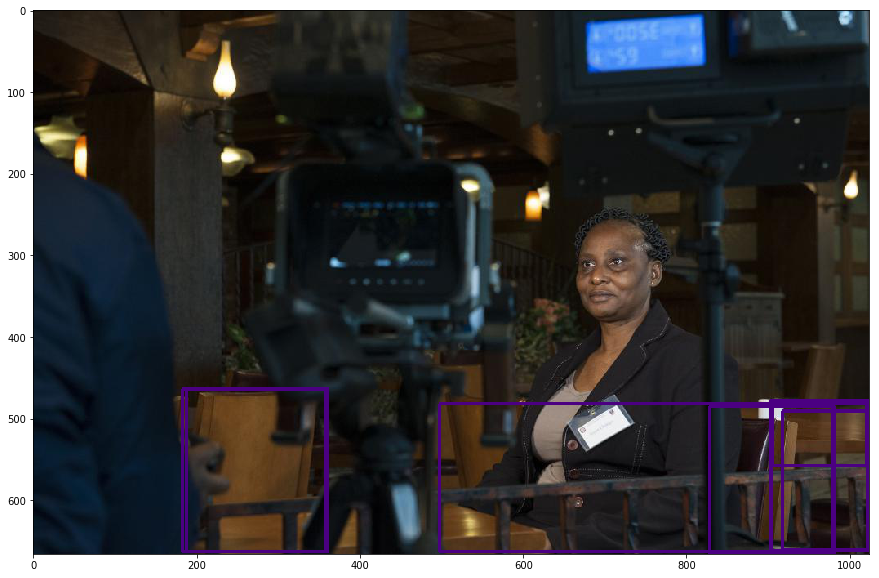

In [55]:
show_preds(2002)

In [23]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


In [24]:
df_test['h'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[1])

In [25]:
df_test['w'] = df_test.ImageId.map(lambda x: get_image_size(os.path.join(TEST_IMG_DIR, '{}.jpg'.format(x)))[0])

In [26]:
df_test.head()

,ImageId,PredictionString,h,w
0,21135d5ed0e7a0b7,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024
1,763c72626bf24534,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,681,1024
2,7540c162180973b1,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024
3,c4e522dce52cb02f,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,768,1024
4,cafcd9496c808085,0.037432 /m/03bt1vf 0.549840 0.603769 0.814588...,682,1024


In [27]:
final_preds = []

for p in tqdm(preds, total=len(preds)):
    final_preds.append(get_preds(p))

100%|██████████| 99999/99999 [00:09<00:00, 10052.98it/s]


In [28]:
total_objs = 0
for p in final_preds:
    total_objs += len(p['labels'])
print(total_objs)

4670810


In [29]:
def get_pred_str(pred, w, h):
    res = []
    for label, score, bbox in zip(pred['labels'], pred['scores'], pred['bboxes']):
        #res.append(classes[label])
        label1, label2 = classes[label].split(',')
        
        res.append('{:.7f}'.format(score))
        res.append(label1)
        res.append('{:.7f}'.format(bbox[0]/w))
        res.append('{:.7f}'.format(bbox[1]/h))
        res.append('{:.7f}'.format(bbox[2]/w))
        res.append('{:.7f}'.format(bbox[3]/h))

        res.append(label2)
        res.append('{:.7f}'.format(bbox[0]/w))
        res.append('{:.7f}'.format(bbox[1]/h))
        res.append('{:.7f}'.format(bbox[2]/w))
        res.append('{:.7f}'.format(bbox[3]/h))
        res.append('is')
        
    res = [str(x) for x in res]
    return ' '.join(res)

In [30]:
pred_strs = []
for i, p in tqdm(enumerate(final_preds), total=len(final_preds)):
    h = df_test.iloc[i].h
    w = df_test.iloc[i].w
    pred_strs.append(get_pred_str(p, w, h))
    

100%|██████████| 99999/99999 [03:17<00:00, 506.42it/s]


In [31]:
pred_strs[:5]

['0.2000768 /m/04bcr3 0.0077109 0.7078724 0.4211004 0.9964237 /m/083vt 0.0077109 0.7078724 0.4211004 0.9964237 is 0.0973429 /m/04bcr3 0.3659443 0.7261045 0.4613051 0.8904796 /m/083vt 0.3659443 0.7261045 0.4613051 0.8904796 is 0.0284815 /m/04bcr3 0.3659885 0.7447231 0.4626206 0.8260456 /m/083vt 0.3659885 0.7447231 0.4626206 0.8260456 is 0.0122667 /m/04bcr3 0.0141165 0.4715450 0.4661392 0.9950985 /m/083vt 0.0141165 0.4715450 0.4661392 0.9950985 is 0.0109923 /m/04bcr3 0.7175416 0.4097975 0.7810670 0.4586873 /m/083vt 0.7175416 0.4097975 0.7810670 0.4586873 is 0.0070447 /m/04bcr3 0.3060260 0.7264281 0.4445199 0.9927783 /m/083vt 0.3060260 0.7264281 0.4445199 0.9927783 is 0.0253799 /m/04bcr3 0.0077109 0.7078724 0.4211004 0.9964237 /m/05z87 0.0077109 0.7078724 0.4211004 0.9964237 is 0.0377631 /m/05r5c 0.2564375 0.4059404 0.3988999 0.7259058 /m/083vt 0.2564375 0.4059404 0.3988999 0.7259058 is 0.0105069 /m/05r5c 0.2192886 0.3818588 0.4484795 0.9774873 /m/083vt 0.2192886 0.3818588 0.4484795 0.977

In [32]:
len(pred_strs)

99999

In [33]:
df_test.PredictionString = pred_strs
df_test.head()

,ImageId,PredictionString,h,w
0,21135d5ed0e7a0b7,0.2000768 /m/04bcr3 0.0077109 0.7078724 0.4211...,682,1024
1,763c72626bf24534,0.6031660 /m/04bcr3 0.6916164 0.8327345 0.9966...,681,1024
2,7540c162180973b1,0.0186181 /m/04bcr3 0.3745526 0.6398759 0.7185...,682,1024
3,c4e522dce52cb02f,0.5046602 /m/04bcr3 0.8350414 0.6735871 0.9927...,768,1024
4,cafcd9496c808085,0.0181822 /m/04dr76w 0.0639186 0.0194453 0.931...,682,1024


In [34]:
df_test.to_csv('sub_is_42_0729.csv', index=False, columns=['ImageId', 'PredictionString'])

In [35]:
!kaggle competitions submit -c open-images-2019-visual-relationship -f sub_is_42_0729.csv -m "submit"

100%|████████████████████████████████████████| 501M/501M [00:14<00:00, 35.0MB/s]
Successfully submitted to Open Images 2019 - Visual Relationship

In [46]:
!head -n 2 sub_is_42_0726_1.csv

ImageId,PredictionString
21135d5ed0e7a0b7,0.4072160 /m/04bcr3 0.0039612 0.7192280 0.4546969 0.9895010 /m/083vt 0.0039612 0.7192280 0.4546969 0.9895010 is 0.0712087 /m/04bcr3 0.3696319 0.7295010 0.4566138 0.8919654 /m/083vt 0.3696319 0.7295010 0.4566138 0.8919654 is 0.0568501 /m/04bcr3 0.0000000 0.7063426 0.0939232 0.9980444 /m/083vt 0.0000000 0.7063426 0.0939232 0.9980444 is 0.0364757 /m/04bcr3 0.3685612 0.7174960 0.4866330 0.9846825 /m/083vt 0.3685612 0.7174960 0.4866330 0.9846825 is 0.0349968 /m/04bcr3 0.0219411 0.6207415 0.7121553 0.9980469 /m/083vt 0.0219411 0.6207415 0.7121553 0.9980469 is 0.0285137 /m/04bcr3 0.3697023 0.7602207 0.4578472 0.8248381 /m/083vt 0.3697023 0.7602207 0.4578472 0.8248381 is 0.0189172 /m/04bcr3 0.3788468 0.6519151 0.7564875 0.9977310 /m/083vt 0.3788468 0.6519151 0.7564875 0.9977310 is 0.0183419 /m/04bcr3 0.0009914 0.7448131 0.0888157 0.8844225 /m/083vt 0.0009914 0.7448131 0.0888157 0.8844225 is 0.0165919 /m/04bcr3 0.3662596 0.7334173 0.5000860 0.8336586 /m